<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/img_processing/stop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case study to find STOP signals in images

Steps


*   Filter red parts
*   Find contours
*   Select octogon comtours


In [1]:
import numpy as np
import skimage
from matplotlib import pyplot as plt

First we download an image with stop signal.

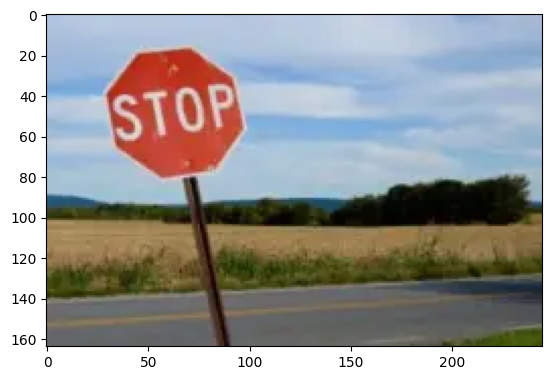

In [2]:
orig_img  = skimage.io.imread('https://cdn.powa.com/baderscott.com/images/wp-content/uploads/2020/06/atlanta-ga-car-accident-lawyer-running-a-stop-signal-300x200-245-critical-desktop.jpg.webp')
skimage.io.imsave('stop.jpg', orig_img)
# remove noise
#img = skimage.filters.gaussian(orig_img, 1)
img = orig_img
fig, ax = plt.subplots()
ax.imshow(orig_img)
#ax[1].imshow(img)
#plt.imshow(img)
#plt.axis("off")

We convert the RGB image to HSV space to separate different shades of red.

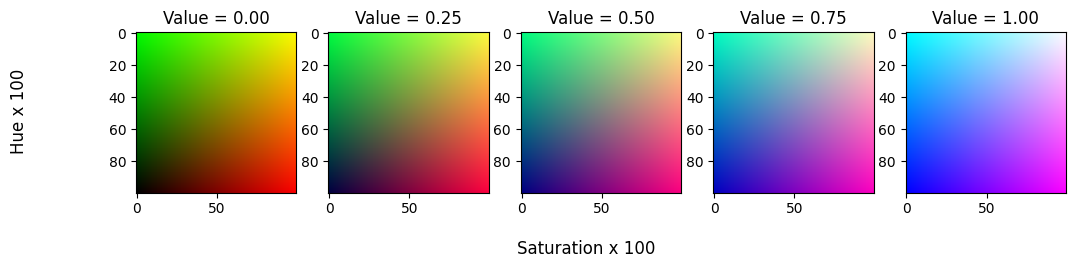

In [3]:
img_hsv = skimage.color.rgb2hsv(img)
isize = 100
h_scale = np.zeros((isize, isize, 3), dtype=img_hsv.dtype)
h = np.arange(0.0, 1.0, 1 / h_scale.shape[1])
for i in range(isize):
        h_scale[i,:,0] = h
        h_scale[:,i,1] = np.flip(h)
icols = 5
fig, ax = plt.subplots(ncols=icols, figsize=(12, 3))
fig.supxlabel('Saturation x 100')
fig.supylabel('Hue x 100')
for i in range(icols):
    v = i / (icols-1)
    h_scale[:,:,2] = v
    ax[i].imshow(h_scale, cmap='hsv')
    ax[i].set_title(f'Value = {v:.2f}')

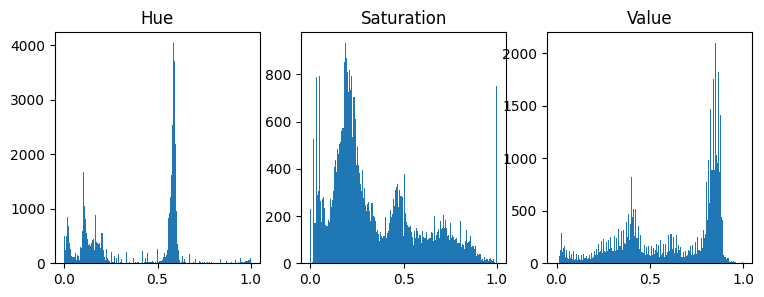

In [4]:
titles = ['Hue', 'Saturation', 'Value']
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(img_hsv[:,:,i].ravel(), 180)
    ax[i].set_title(titles[i])

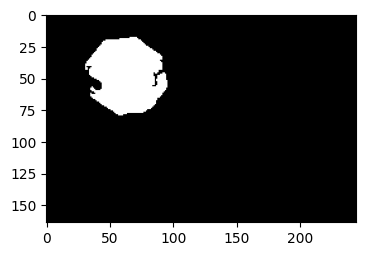

In [12]:
img_bin = ((img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,0] < 0.1) & (img_hsv[:,:,2] > 0.3) | # red pixels
            ((img_hsv[:,:,0] < 0.2) | (img_hsv[:,:,0] > 0.8)) & (img_hsv[:,:,1] < 0.3) & (img_hsv[:,:,2] > 0.8)) # white pixels
#img_bin = (img_hsv[:,:,0] > 0.9) & (img_hsv[:,:,1] > 0.8)
#img_bin1 = skimage.morphology.area_closing(img_bin)
img_bin = skimage.morphology.remove_small_objects(img_bin)
img_bin = skimage.morphology.remove_small_holes(img_bin, 200)
fig, ax0 = plt.subplots(figsize=(4, 3))
ax0.imshow(img_bin, cmap='gray')

1

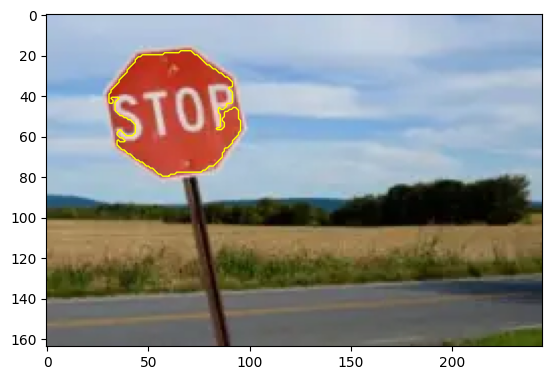

In [13]:
cnts = skimage.measure.find_contours(img_bin)
fig, ax = plt.subplots()
ax.imshow(img)
for contour in cnts:
    ax.plot(contour[:, 1], contour[:, 0], c="yellow", linewidth=1)

len(cnts)